In [1]:
import sys,os,os.path
sys.path.append("/Users/user/Desktop/PhD/Repositories/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
if not os.environ.get("ICTDIR"):
    os.environ["ICTDIR"] = "/Users/user/Desktop/PhD/Repositories/IC"

import invisible_cities.core.core_functions as     coref
import invisible_cities.io  .dst_io         as     dstio
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df
from invisible_cities.database.load_db  import DataPMT, DataSiPM


from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [8, 6]
rcParams['font.size'] = 15


import re
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import tables

from scipy.spatial import cKDTree
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from   invisible_cities.database               import load_db

from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df

In [18]:
detector_info = load_db.DataSiPM('next100', 0)

In [ ]:
def median_std_method(wfs, nsigma=3):
    charges = np.sum(wfs, axis=1)
    threshold = np.median(charges) + nsigma * np.std(charges)
    return charges >= threshold


def hard_cut_method(wfs, threshold=5):
    charges = np.sum(wfs, axis=1)
    return charges >= threshold


def top_n_method(wfs, n=10):
    charges = np.sum(wfs, axis=1)
    idx = np.argsort(charges)[-n:]

    selected_ids = np.zeros_like(charges, dtype=bool)
    selected_ids[idx] = True
    return selected_ids

In [30]:
def kill_isolated_sipms(selected_ids, sipm_x, sipm_y, proximity_threshold):
    selected_ids_no_isolated = selected_ids.copy()

    for i in np.where(selected_ids)[0]:
        x, y = sipm_x[i], sipm_y[i]

        distances = np.sqrt((sipm_x - x)**2 + (sipm_y - y)**2)

        n_neighbors = np.sum((distances < proximity_threshold) & selected_ids)

        if n_neighbors <= 1:
            selected_ids_no_isolated[i] = False

    return selected_ids_no_isolated

In [31]:
def apply_radius_padding(selected_ids_no_isolated, sipm_x, sipm_y, radius_cut):
    sipm_ids_with_signal = np.zeros_like(selected_ids_no_isolated, dtype=bool)

    for i in np.where(selected_ids_no_isolated)[0]:
        x, y = sipm_x[i], sipm_y[i]
        distances = np.sqrt((sipm_x - x)**2 + (sipm_y - y)**2)
        sipm_ids_with_signal |= distances < radius_cut

    return sipm_ids_with_signal


In [32]:
def make_sipm_selection(wfs, selection_func, selection_kwargs, 
                        proximity_threshold, padding):
    """
    SiPM selection pipeline, applies SiPM cuts based on user input.
    A first selection of SiPMs is made, isolated SiPMs are removed
    and padding is added around the SiPMs that are left.

    Parameters
    ----------
    wfs : object
        Contains the waveforms of each SiPM.
    selection_func : callable
        Function returning a boolean mask of energetic SiPMs.
    selection_kwargs : dict
        Arguments passed to selection_func.
    proximity_threshold : float
        Threshold used to identify isolated SiPMs.
    padding : float
        Radial padding added to each SiPM that passes the selections.
    """

    sipm_x = detector_info.X
    sipm_y = detector_info.Y

    selected_ids = selection_func(wfs, **selection_kwargs)

    selected_ids_no_isolated = kill_isolated_sipms(
        selected_ids,
        sipm_x,
        sipm_y,
        proximity_threshold
    )

    sipm_ids_with_signal = apply_radius_padding(
        selected_ids_no_isolated,
        sipm_x,
        sipm_y,
        padding
    )

    return sipm_ids_with_signal


# test if this works

In [ ]:
filename = '/Users/user/Desktop/PhD/NEXT/NEXT_testing/irene_files/15539/zero_cuts/run_15539_0001_ldc1.pmaps'

with tb.open_file(filename) as file:

    pmaps    = load_pmaps      (filename)
    pmt_info = file.root.PMAPS.S2Pmt
    sipm_info = file.root.PMAPS.S2Si

all_events = list(pmaps.keys())
s2 = pmaps[all_events[4]].s2s[0]
sipm = s2.sipms
pmt = s2.pmts
wfs = sipm.all_waveforms

In [ ]:
sipm_mask = make_sipm_selection(wfs, median_std_method, {'nsigma': 3}, 25, 35)

In [52]:
def plot_sipms(sipm, energetic_sipm_mask, radius_cut=75):

    max_sipm_id = np.where(sipm.sum_over_times == sipm.sum_over_times.max())[0][0]

    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    sipm_charge_time_summed = sipm.sum_over_times
    sipm_ids = sipm.ids

    sipm_x_max = detector_info.X[max_sipm_id]
    sipm_y_max = detector_info.Y[max_sipm_id]

    min_amplitude = 0.0
    mask = sipm_charge_time_summed > min_amplitude

    sipm_x_active = detector_info.X[mask]
    sipm_y_active = detector_info.Y[mask]

    def make_circle(x, y, radius):
        circle = patches.Circle((x, y), radius, edgecolor='r', facecolor='none', linestyle='--', linewidth=2
                                )
        return circle
    
    fig, ax = plt.subplots(figsize=(9.7, 8))

    #ax.add_patch(make_circle(sipm_x_max, sipm_y_max, 75))


    sipm_amplitude = sipm_charge_time_summed

    ax.scatter(
        sipm_x_all,
        sipm_y_all,
        color="k",
        s=0.5
    )
    sc = ax.scatter(
        sipm_x_active,
        sipm_y_active,
        c=sipm_amplitude[mask],
        cmap="viridis",
        s=10,
        label="Active SiPMs"
    )

    ax.scatter(
        sipm_x_all[energetic_sipm_mask],
        sipm_y_all[energetic_sipm_mask],
        edgecolor='r',
        facecolor='none',
        s=50,
        label=f"SiPMs within {radius_cut} mm"
    )

    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_title("SiPMs >3 sigma with 50mm padding & 35mm proximity cut")

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("SiPM amplitude (PEs)")

    plt.show()

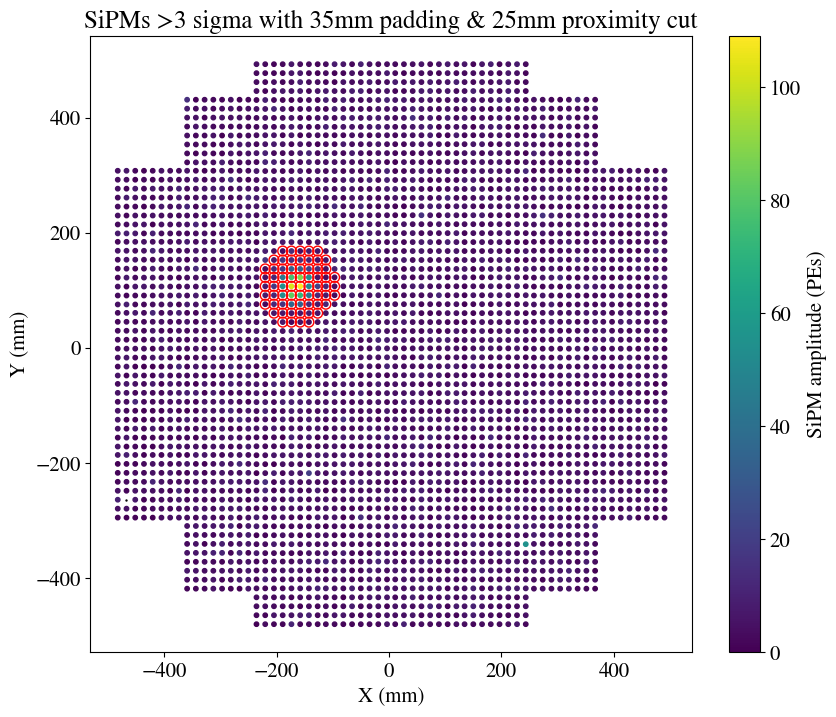

In [ ]:
plot_sipms(sipm, sipm_mask)

In [ ]:
filename = '/Users/user/Desktop/PhD/NEXT/NEXT_testing/studying_HE_files/HE_data/one_event_pmap.pmaps'

with tb.open_file(filename) as file:

    pmaps_HE    = load_pmaps      (filename)
    pmt_info_HE = file.root.PMAPS.S2Pmt
    sipm_info_HE = file.root.PMAPS.S2Si

all_events_HE = list(pmaps_HE.keys())
s2_HE = pmaps_HE[all_events_HE[0]].s2s[4]
sipm_HE = s2_HE.sipms
pmt_HE = s2_HE.pmts
wfs_HE = sipm_HE.all_waveforms


In [ ]:
sipm_mask_HE = make_sipm_selection(wfs_HE, median_std_method, {'nsigma': 3}, 35, 50)

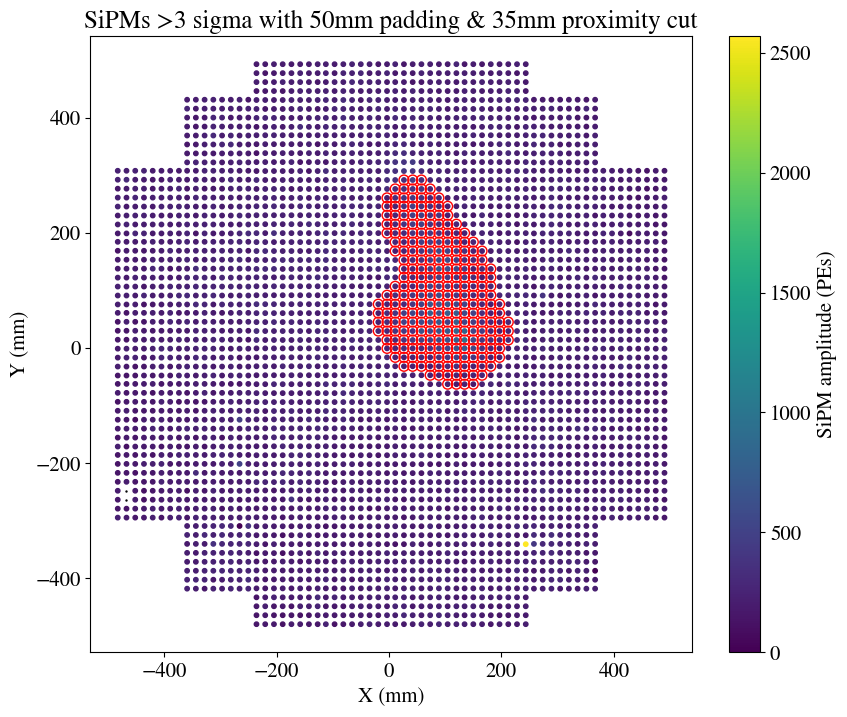

In [53]:
plot_sipms(sipm_HE, sipm_mask_HE)